In [1]:
#pip install pyarrow fastparquet pandas==1.3.5

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing,


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score

In [5]:
df = pd.concat(objs=[
    pd.read_parquet('cidds-001-openstack.parquet'),
    pd.read_parquet('cidds-001-externalserver.parquet')
], copy=False, sort=False, ignore_index=True)
df.shape

(4366182, 15)

In [6]:
df.head()

,duration,proto,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,label,attack_type,attack_id
0,0.018,TCP,2,338.0,1,0,1,1,0,0.0,0.0,0,normal,benign,0
1,0.000,TCP,1,212.0,1,0,1,1,0,0.0,0.0,32,normal,benign,0
2,0.000,TCP,1,108.0,1,0,1,1,0,0.0,0.0,0,normal,benign,0
3,0.006,TCP,2,174.0,1,0,1,1,0,0.0,0.0,0,normal,benign,0
4,0.019,TCP,2,338.0,1,0,1,1,0,0.0,0.0,0,normal,benign,0


In [7]:
df.isnull().sum()

duration       0
proto          0
packets        0
bytes          0
flows          0
tcp_urg        0
tcp_ack        0
tcp_psh        0
tcp_rst        0
tcp_syn        0
tcp_fin        0
tos            0
label          0
attack_type    0
attack_id      0
dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

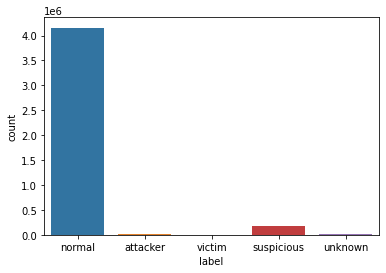

In [8]:
sns.countplot(x=df['label'])

<AxesSubplot:xlabel='attack_type', ylabel='count'>

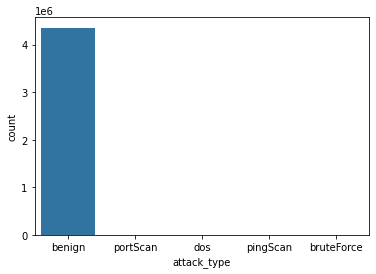

In [9]:
sns.countplot(x=df['attack_type'])

In [10]:
df = df.drop(columns=['label', 'attack_id'])
df.shape

(4366182, 13)

In [11]:
df['proto'] = df['proto'].astype('object')
df['proto'] = df['proto'].str.strip()
df['proto'] = df['proto'].astype('category')
df['proto'] = df['proto'].cat.codes
df['proto'] = df['proto'].astype(np.int32)

In [12]:
df['attack_type'] = df['attack_type'].astype('object')
df.loc[df['attack_type'] != 'benign', 'attack_type'] = 1
df.loc[df['attack_type'] == 'benign', 'attack_type'] = 0
print(df['attack_type'].value_counts())
df['attack_type'] = df['attack_type'].astype(dtype=np.int32)

0    4354307
1      11875
Name: attack_type, dtype: int64


In [13]:
target = 'attack_type'
conts = list(df.columns.difference([target]).values)
len(conts)

12

In [14]:
df_train = df.sample(frac=0.2, replace=False)
df_test = df.drop(index=df_train.index)
df_train.shape, df_test.shape

((873236, 13), (3492946, 13))

In [15]:
df_train.groupby('attack_type')['tcp_ack'].value_counts()

attack_type  tcp_ack
0            1          861234
             0            9693
1            1            1920
             0             389
Name: tcp_ack, dtype: int64

In [16]:
def xs_y(df_, targ): 
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

In [17]:
X_train, y_train = xs_y(df_train, targ=target)
X_test, y_test = xs_y(df_test, targ=target)

In [18]:
X_train.shape

(873236, 12)

<AxesSubplot:xlabel='attack_type', ylabel='count'>

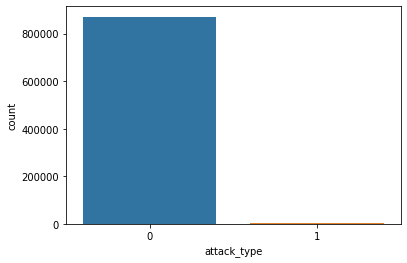

In [19]:
sns.countplot(x=df_train['attack_type'])

In [20]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []
auroc = []


#function to call for storing the results
def storeResults(model, a,b,c,d,e):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))
    auroc.append(round(e, 3))

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = tree.predict(X_test)

dt_acc = accuracy_score(y_pred, y_test)
dt_prec = precision_score(y_pred, y_test)
dt_rec = recall_score(y_pred, y_test)
dt_f1 = f1_score(y_pred, y_test)
dt_auroc = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])

In [33]:
storeResults('Decision Tree Classifier',dt_acc,dt_prec,dt_rec,dt_f1,dt_auroc)

# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

# instantiate the model 
lr = LogisticRegression()

# fit the model 
lr.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_pred, y_test)
lr_prec = precision_score(y_pred, y_test)
lr_rec = recall_score(y_pred, y_test)
lr_f1 = f1_score(y_pred, y_test)
lr_auroc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

In [34]:
storeResults('Logistic Regression',lr_acc,lr_prec,lr_rec,lr_f1,lr_auroc)

# MLP

In [25]:
from sklearn.neural_network import MLPClassifier
# instantiate the model 
mlp = MLPClassifier(random_state=1, max_iter=30)

# fit the model 
mlp.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = mlp.predict(X_test)

mlp_acc = accuracy_score(y_pred, y_test)
mlp_prec = precision_score(y_pred, y_test)
mlp_rec = recall_score(y_pred, y_test)
mlp_f1 = f1_score(y_pred, y_test)
mlp_auroc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

In [35]:
storeResults('MLP Classifier',mlp_acc,mlp_prec,mlp_rec,mlp_f1,mlp_auroc)

# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(random_state=40)

# fit the model 
rf.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_pred, y_test)
rf_prec = precision_score(y_pred, y_test)
rf_rec = recall_score(y_pred, y_test)
rf_f1 = f1_score(y_pred, y_test)
rf_auroc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

In [36]:
storeResults('Random Foresy Classifier',rf_acc,rf_prec,rf_rec,rf_f1,rf_auroc)

# SVM

In [29]:
from sklearn.svm import SVC

# instantiate the model 
svm = SVC(probability=True)

# fit the model 
svm.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = svm.predict(X_test)

svc_acc = accuracy_score(y_pred, y_test)
svc_prec = precision_score(y_pred, y_test)
svc_rec = recall_score(y_pred, y_test)
svc_f1 = f1_score(y_pred, y_test)
svc_auroc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])

In [37]:
storeResults('SVM',svc_acc,svc_prec,svc_rec,svc_f1,svc_auroc)

# Comparison

In [38]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score,
                        'AUC-ROC' : auroc
                      })

In [39]:
result

,ML Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Decision Tree Classifier,0.999,0.856,0.850,0.853,0.935
1,Logistic Regression,0.997,0.000,0.000,0.000,0.927
2,MLP Classifier,0.988,0.549,0.119,0.195,0.843
3,Random Foresy Classifier,0.999,0.862,0.906,0.884,0.982
4,SVM,0.997,0.000,0.000,0.000,0.189


# Modelling

In [40]:
import joblib
filename = 'model.sav'
joblib.dump(rf, filename)

['model.sav']

# Graph

In [41]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

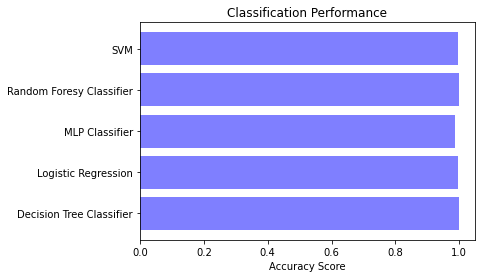

In [42]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

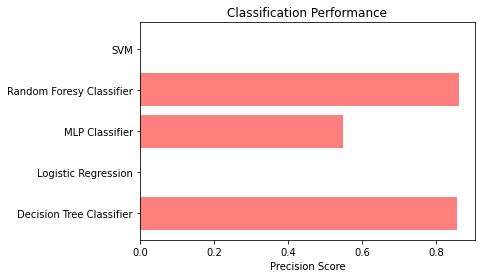

In [43]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

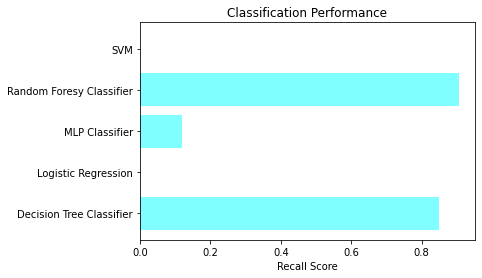

In [44]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='cyan')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

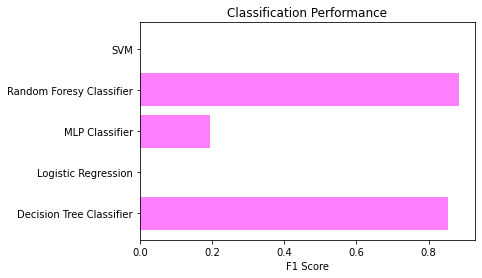

In [45]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='magenta')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

# AUC ROC

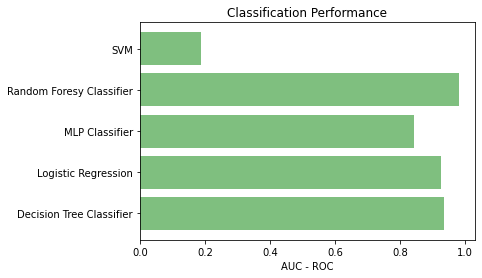

In [46]:
plt2.barh(y_pos, auroc, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('AUC - ROC')
plt2.title('Classification Performance')
plt2.show()